In [6]:
import torch
import os
from itertools import product
from random import shuffle
from tqdm import tqdm

from KNN_Embeddings import *

(50000, 768)
Accuracy: 0.987
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1000
           1       0.98      0.99      0.99      1000
           2       1.00      0.98      0.99      1000
           3       0.96      0.98      0.97      1000
           4       0.98      0.99      0.99      1000
           5       0.99      0.96      0.98      1000
           6       0.99      0.99      0.99      1000
           7       1.00      1.00      1.00      1000
           8       1.00      1.00      1.00      1000
           9       0.99      0.98      0.99      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
[[997   0   0   0   0   0   0   0   3   0]
 [  0 992   0   0   0   0   0   0   0   8]
 [  5   0 979   3   7   0   6   0   0   0]
 [  2   2   1 982   3   6   4   0   0   0]

In [7]:
# Feature normalization
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset
import random

class TripletDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        # Ensure labels are in a flat, 1D array
        if labels.dim() > 1:
            labels = labels.view(-1)
        self.labels = labels
        self.labels_set = set(labels.numpy())
        self.label_to_indices = {label: np.where(labels.numpy() == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        anchor = self.embeddings[index]
        anchor_label = self.labels[index].item()
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.label_to_indices[anchor_label])
        negative_label = random.choice(list(self.labels_set - {anchor_label}))
        negative_index = random.choice(self.label_to_indices[negative_label])
        positive = self.embeddings[positive_index]
        negative = self.embeddings[negative_index]
        return anchor, positive, negative, anchor_label, negative_label

    def __len__(self):
        return len(self.embeddings)


# Create a scaler object
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TripletDataset(X_train_tensor, y_train_tensor)
test_dataset = TripletDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)



## Model 

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class TCL(nn.Module):
    def __init__(self, input_dim, num_bits):
        super(TCL, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, num_bits)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.tanh(x)  # Ensuring outputs are bounded between -1 and 1
        x = F.normalize(x, p=2, dim=1)  # L2 normalization
        return x

def to_one_hot(labels, num_classes):
    """ Convert labels to one-hot encoded format """
    return torch.eye(num_classes)[labels].to(labels.device)

class BinaryTripletCenterLoss(nn.Module):
    def __init__(self, margin=5, num_classes=10, feat_dim=12):
        super(BinaryTripletCenterLoss, self).__init__()
        self.margin = margin
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.ranking_loss = nn.MarginRankingLoss(margin=margin)

    def forward(self, inputs, targets):
        # Ensure inputs are on the same device as centers
        # device = self.centers.device
        # inputs = inputs.view(inputs.size(0), -1).to(device)
        # targets = targets.to(device)
        
        # Continuous to binary approximation
        binary_inputs = torch.sign(inputs)  # Convert to -1 or 1 to simulate binary codes

        # Compute all pairwise distances between binary inputs and class centers
        all_dists = torch.cdist(binary_inputs, self.centers, p=2).pow(2)

        if targets.dim() > 1 and targets.size(1) == 1:
            targets = targets.squeeze(1) 

        # print("binary_inputs size:", binary_inputs.size())  # Expected: [batch_size, feat_dim]
        # print("centers size:", self.centers.size()) # Expected: [num_classes, feat_dim]

        # Extract the intra-class distances before setting them to inf
        intra_class_dists = all_dists.gather(1, targets.unsqueeze(1)).squeeze(1)

        # Set distances from each sample to its own class center to large number
        # This avoids them being picked as the minimum inter-class distance

        mask = torch.ones_like(all_dists)
        mask[torch.arange(inputs.size(0)), targets] = 0
        inter_class_dists = all_dists * mask
        min_inter_class_dists, _ = torch.min(inter_class_dists + (1 - mask) * 1e12, dim=1)

        # print("all_dists size:", all_dists.size())
        # print("targets size:", targets.unsqueeze(1).size())


        differences = min_inter_class_dists - intra_class_dists + self.margin
        losses = torch.clamp(differences, min=0)

        return losses.mean()  # Return the mean loss over the batch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCL(input_dim=X_train_tensor.shape[1], num_bits=12).to(device)
loss_func = BinaryTripletCenterLoss(margin=5.0, num_classes=10, feat_dim=12).to(device)
softmax_loss = nn.CrossEntropyLoss()
lambda_param = 0.01  # Balance between TCL and softmax loss
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-5)



In [9]:
for epoch in range(10):  # number of epochs
    model.train()
    total_loss = 0
    total_triplet_loss = 0
    total_softmax_loss = 0
    for batch_idx, (anchor, positive, negative, anchor_label, negative_label) in enumerate(train_loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        labels = torch.cat([anchor_label, anchor_label, negative_label]).to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        # Calculating triplet loss
        triplet_loss = loss_func(torch.cat([anchor_out, positive_out, negative_out]), labels)

        # Softmax loss for only the anchor outputs against its labels
        class_loss = softmax_loss(anchor_out, anchor_label.to(device))

        # Combining losses
        combined_loss = (1 - lambda_param) * triplet_loss + lambda_param * class_loss
        combined_loss.backward()
        optimizer.step()

        total_loss += combined_loss.item()
        total_triplet_loss += triplet_loss.item()
        total_softmax_loss += class_loss.item()

    # Logging the losses
    print(f'Epoch {epoch+1}, Total Loss: {total_loss / len(train_loader)}, '
          f'Triplet Loss: {total_triplet_loss / len(train_loader)}, '
          f'Softmax Loss: {total_softmax_loss / len(train_loader)}')

Epoch 1, Total Loss: 1.0674538857796614, Triplet Loss: 1.0593579310895231, Softmax Loss: 1.8689521121247041
Epoch 2, Total Loss: 0.9556118376419672, Triplet Loss: 0.9480718413124913, Softmax Loss: 1.7020705886509107
Epoch 3, Total Loss: 0.9375085986559958, Triplet Loss: 0.9300809844832896, Softmax Loss: 1.6728414198016877
Epoch 4, Total Loss: 0.9244088344561779, Triplet Loss: 0.917011283547677, Softmax Loss: 1.6567657609729816
Epoch 5, Total Loss: 0.9213696199914684, Triplet Loss: 0.9140509081161236, Softmax Loss: 1.6459214719360138
Epoch 6, Total Loss: 0.8991180775720445, Triplet Loss: 0.8916545304114861, Softmax Loss: 1.6380084065525122
Epoch 7, Total Loss: 0.8975846714833203, Triplet Loss: 0.8901677307722818, Softmax Loss: 1.6318609584932742
Epoch 8, Total Loss: 0.8839406843304329, Triplet Loss: 0.8764357678496929, Softmax Loss: 1.6269267669419194
Epoch 9, Total Loss: 0.8906024528281463, Triplet Loss: 0.883207644914727, Softmax Loss: 1.6226878259188073
Epoch 10, Total Loss: 0.887740

In [10]:
def compute_class_metrics(embeddings, labels):
    unique_labels = torch.unique(labels)
    centroids = []
    intra_class_distances = []

    # Compute centroids and intra-class distances
    for label in unique_labels:
        class_samples = embeddings[labels == label]
        centroid = class_samples.mean(dim=0)
        centroids.append(centroid)
        intra_class_distances.append((class_samples - centroid).pow(2).sum(1).mean().item())

    # Compute inter-class distances
    centroids = torch.stack(centroids)
    inter_class_distances = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            distance = (centroids[i] - centroids[j]).pow(2).sum().item()
            inter_class_distances.append(distance)

    return {
        "average_intra_class_distance": sum(intra_class_distances) / len(intra_class_distances),
        "average_inter_class_distance": sum(inter_class_distances) / len(inter_class_distances)
    }




## KNN on hashed embeddings

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for anchor, _, _, label_a, _ in test_loader:  # Correctly unpack all elements
            anchor = anchor.to(device)
            output = model(anchor)
            embeddings.append(output.cpu())
            labels.append(label_a)
    embeddings = torch.cat(embeddings)
    labels = torch.cat(labels)
    return embeddings, labels

# Ensure model and device are defined and properly initialized
# Example: model = DPSH(input_dim=X_train.shape[1], num_bits=48).to(device)
# and device is defined like device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract hash codes
train_codes, train_labels = evaluate_model(model, train_loader, device)
test_codes, test_labels = evaluate_model(model, test_loader, device)

# Classification with KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='hamming')

# optimization: get the best k on the original dataset and use same k on hashed dataset

knn.fit(train_codes, train_labels)
predictions = knn.predict(test_codes)
y_pred_proba = knn.predict_proba(test_codes)

print(classification_report(test_labels, predictions))

# Binarize the labels for a one-vs-rest computation
y_test_binarized = label_binarize(test_labels, classes=np.unique(train_labels))  # Updated to use `test_labels`

# Calculate the average precision for each class
average_precisions = []
for i in range(y_test_binarized.shape[1]):  # iterate over classes
    average_precisions.append(average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i]))

# Compute the mean of the average precisions
map_score = np.mean(average_precisions)
print(f'Mean Average Precision (MAP): {map_score}')


In [12]:
train_embeddings, train_labels = evaluate_model(model, train_loader, device)
metrics = compute_class_metrics(train_embeddings, train_labels)

print("Average Intra-class Distance:", metrics["average_intra_class_distance"])
print("Average Inter-class Distance:", metrics["average_inter_class_distance"])

Average Intra-class Distance: 0.07138977311551571
Average Inter-class Distance: 2.0240036964416506


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.032s...
[t-SNE] Computed neighbors for 50000 samples in 14.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

/tmp/ipykernel_464335/960856241.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)  # Colormap with enough colors


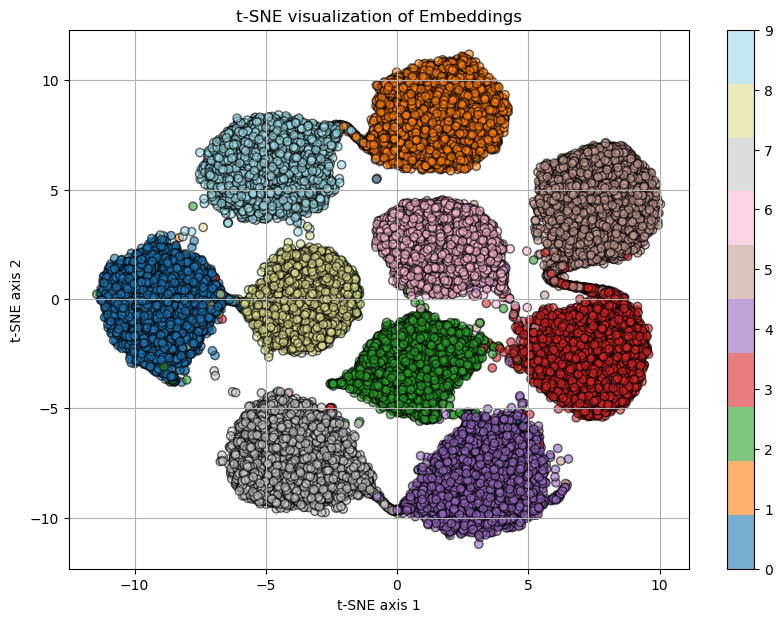

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, labels, num_classes):
    # Convert labels from tensor to numpy if not already
    labels = labels.numpy() if not isinstance(labels, np.ndarray) else labels

    # Initialize t-SNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings)

    # Plotting the results of t-SNE
    plt.figure(figsize=(10, 7))
    cmap = plt.cm.get_cmap('tab20', num_classes)  # Colormap with enough colors
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, marker='o', edgecolor='k', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of Embeddings')
    plt.xlabel('t-SNE axis 1')
    plt.ylabel('t-SNE axis 2')
    plt.grid(True)
    plt.show()

train_embeddings, train_labels = evaluate_model(model, train_loader, device)  # Make sure these are on CPU
visualize_embeddings(train_embeddings.numpy(), train_labels, len(np.unique(train_labels.numpy())))
